In [1]:
import genomeview
from genomeview.bamtrack import SingleEndBAMTrack, PairedEndBAMTrack
import genomeview.axis
import genomeview.graphtrack
from genomeview import genomesource

## Download some example data, if necessary

In [2]:
import gzip
import io
import os
import urllib.request

genome_path = "data/chr14.fa"

if not os.path.exists("data/pacbio.chr14.bam"):
    raise Exception("Make sure to run jupyter notebook from the genomeview examples directory.")
    
if not os.path.exists(genome_path):
    print("reference chrom 14 not found; downloading...")
    r = urllib.request.urlopen("http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr14.fa.gz")
    z = gzip.GzipFile(fileobj=io.BytesIO(r.read()), mode="rb")
    f = open(genome_path, "wb")
    f.write(z.read())
    print("...done.")
else:
    print("Genome and bam files found, no further action required")

Genome and bam files found, no further action required


## Some basic code to visualize a set of bams

In [5]:
track_info = {"illumina":"data/illumina.chr14.bam",
              "pacbio":"data/pacbio.chr14.bam"
              }
chrom = "14"
start = 66901400

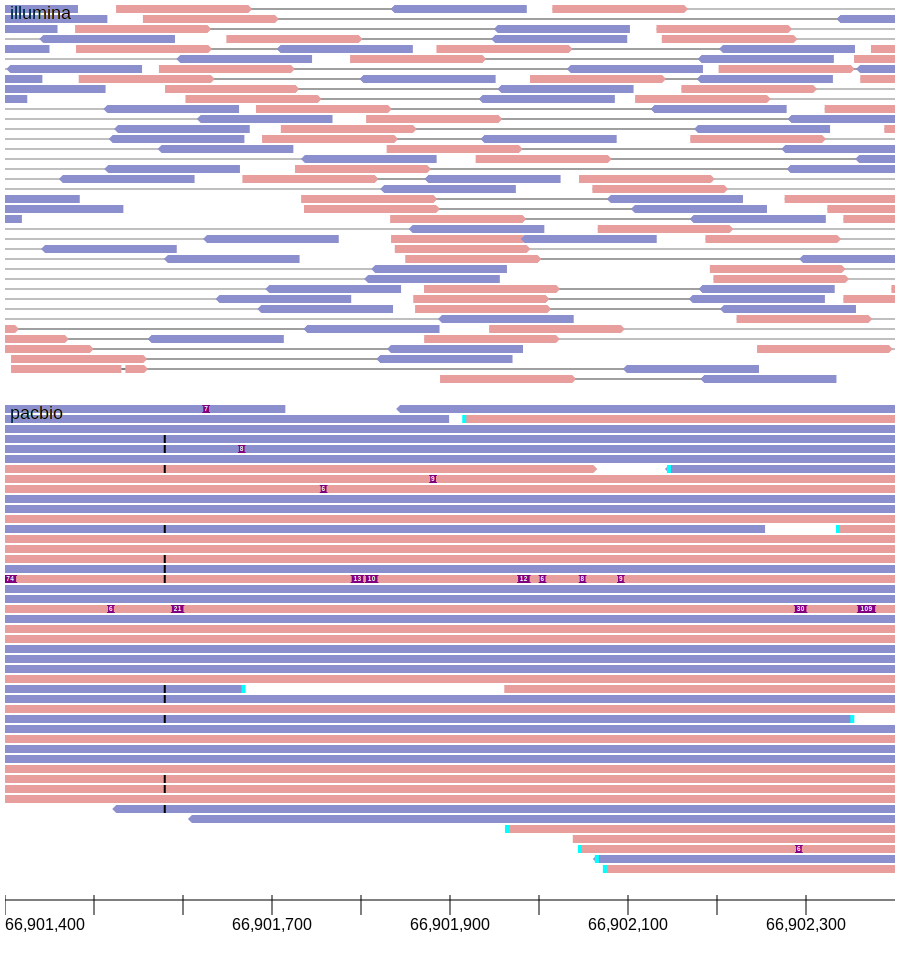

In [7]:
tracks = genomeview.visualize_data(track_info, chrom, start, start+1000, genome_path)
tracks

# Using python to extend functionality

Let's take advantage of the fact that we're doing all the drawing in python, and use a custom function to determine the color of the read pairs.

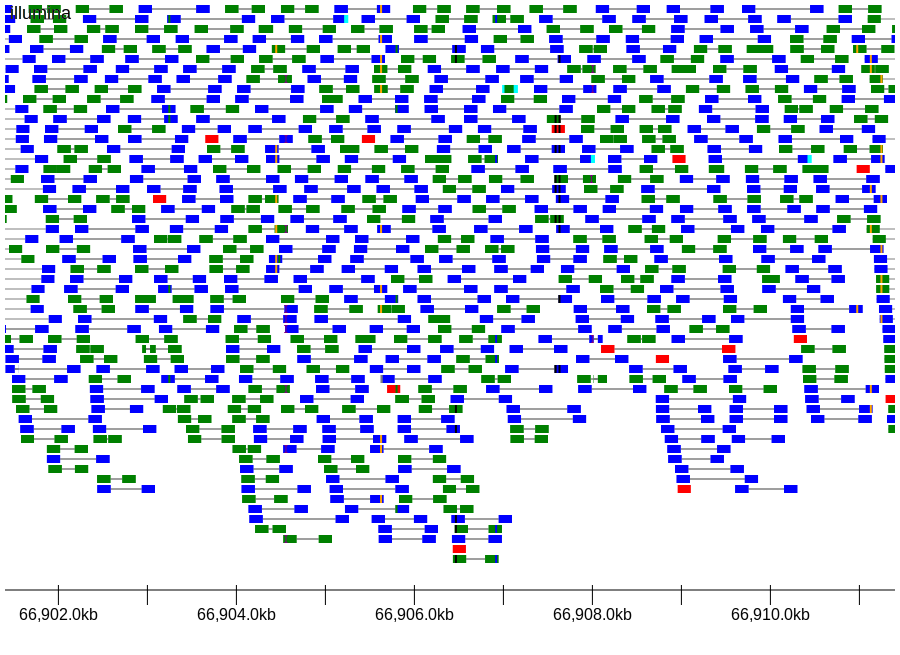

In [5]:
def color_by_insert_size(interval):
    if abs(interval.read.isize) < 100 or abs(interval.read.isize) > 1500:
        return "red"
    if abs(interval.read.isize) > 550:
        return "blue"
    return "green"

# let's just render the illumina data
cur_paths = {key:track_info[key] for key in ["illumina"]}
doc = genomeview.visualize_data(cur_paths, chrom, start, start+10000, genome_path)

track = genomeview.get_one_track(doc, "illumina")
track.color_fn = color_by_insert_size 

doc

**performance is reasonably fast** - note that the pacbio "quick consensus" viewing takes the bulk of the time

In [6]:
%timeit svg = "\n".join(tracks.render())

576 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Modular design
Components can be grouped together, not only vertically (as above) but also horizontally, as demonstrated below.

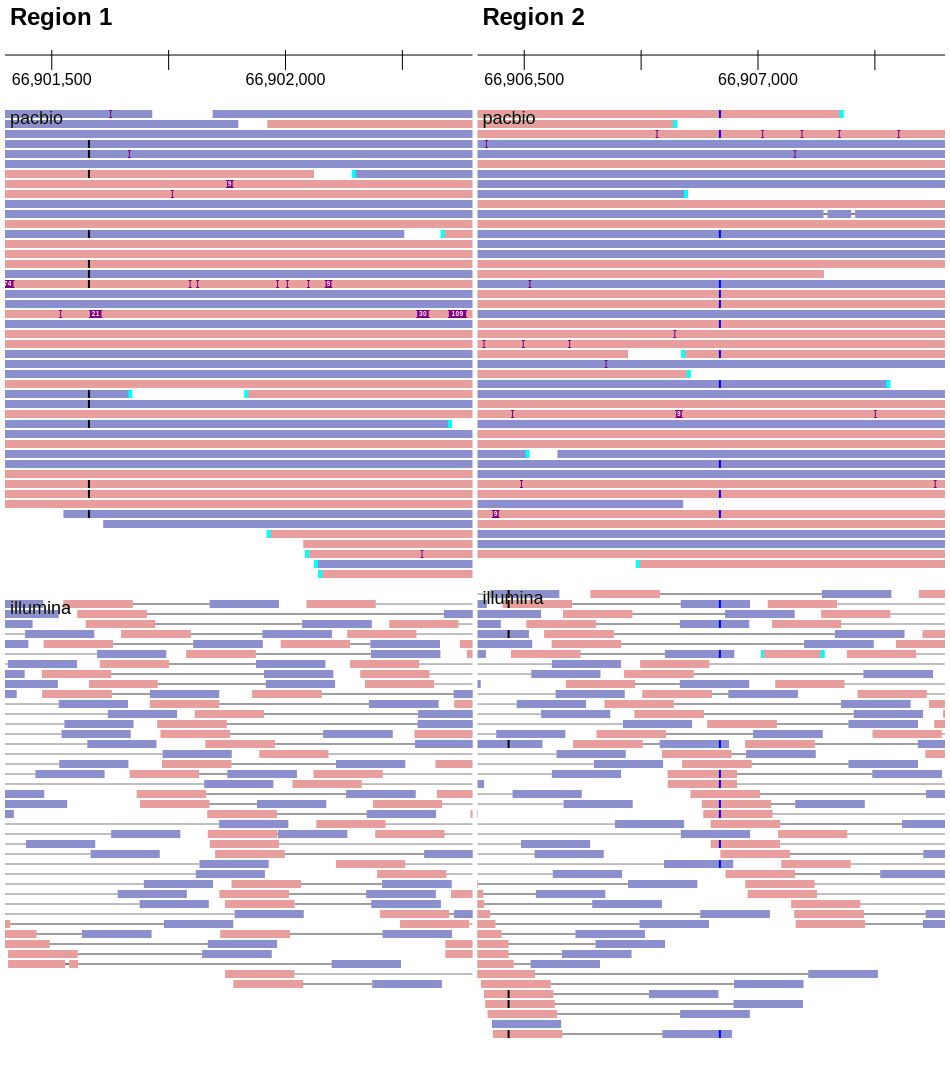

In [7]:
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

row = genomeview.ViewRow("row")


for i, cur_start in enumerate([start, start+5000]):
    cur_doc = genomeview.visualize_data(
        track_info, chrom, cur_start, cur_start+1000, genome_path, axis_on_top=True)
    gv = cur_doc.elements[0]

    # Add a text label
    label_track = genomeview.track.TrackLabel("Region {}".format(i+1))
    gv.tracks.insert(0, label_track)
    
    # Add the genome view to the end of the row
    row.add_view(gv)
    
doc.elements.append(row)
doc

## Custom drawing callbacks

Pre-renderers and post-renderers are code that get run before and after (respectively) drawing the track. This allows compositing additional visual elements such as highlighting a genomic region or adding text, without creating a custom Track subclass.

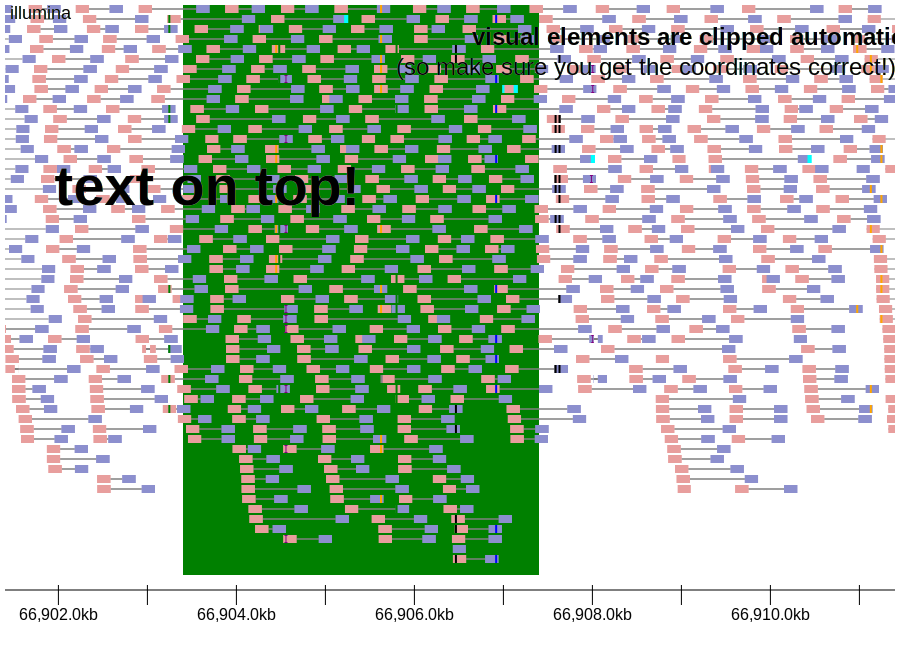

In [8]:
def prerender(renderer, element):
    # prerenderers get run before the track is rendered
    x1 = element.scale.topixels(start+2000) # converting genomic coordinates to screen coordinates
    x2 = element.scale.topixels(start+6000)
    yield from renderer.rect(x1, 0, x2-x1, element.height, fill="green", stroke="none")
    
def postrender(renderer, element):
    # we'll render this with screen coordinates (not genomic coordinates)
    yield from renderer.text_with_background(
        200, 200, "text on top!", size=56, bg_opacity=1.0, **{"font-weight":"bold"})
    
    width = element.scale.pixel_width
    yield from renderer.text_with_background(
        width+50, 40, "visual elements are clipped automatically", size=24, bg_opacity=1.0, 
        anchor="end", **{"font-weight":"bold"})
    yield from renderer.text_with_background(
        width, 70, "(so make sure you get the coordinates correct!)", size=24, bg_opacity=1.0, 
        anchor="end")


doc = genomeview.visualize_data(cur_paths, chrom, start, start+10000, genome_path)
cur_track = genomeview.get_one_track(doc, "illumina")
cur_track.prerenderers = [prerender]
cur_track.postrenderers = [postrender]

doc

# Grouping read data by tag, etc

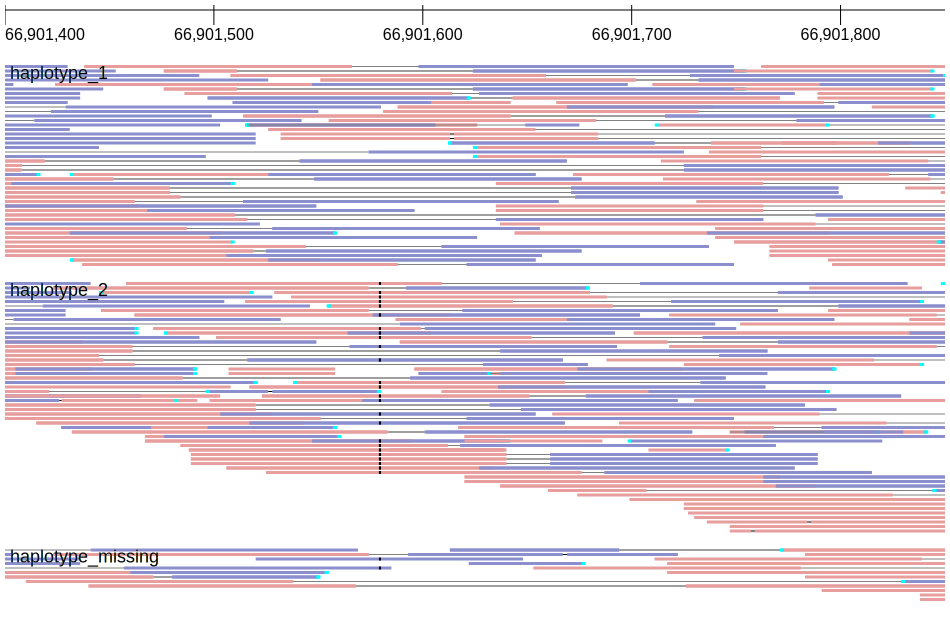

In [9]:
import pysam
import genomeview.track
from genomeview.utilities import match_chrom_format

class MyPairedEndBAMTrack(PairedEndBAMTrack):
    def __init__(self, *args, **kwdargs):
        super().__init__(*args, **kwdargs)
        self.row_height = 3
        self.margin_y = 1.5
        
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

gv = genomeview.genomeview.GenomeView(chrom, start, start+450, "+", source)

# Add the coordinate axis at the top
axis = genomeview.axis.Axis()
gv.add_track(axis)

bam_track = genomeview.bamtrack.GroupedBAMTrack("data/10x.chr14.bam", 
                                                genomeview.bamtrack.get_group_by_tag_fn("HP"),
                                                MyPairedEndBAMTrack)
bam_track.category_label_fn = lambda x: "haplotype_{}".format(x)
gv.add_track(bam_track)

doc.elements.append(gv)

doc

# All together

/Users/nspies/Projects/genomeview/genomeview/bamtrack.py:153: RuntimeWarning: invalid value encountered in true_divide
  if not self.mismatch_counts or alt=="N" or self.mismatch_counts.query(alt, genome_position+i):


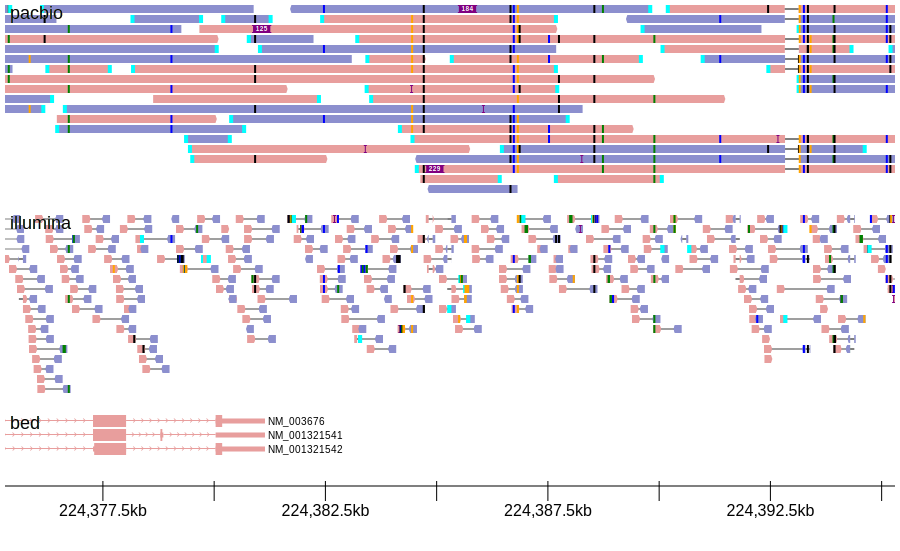

In [20]:
dataset_paths = {"pacbio":"data/pacbio.chr1.bam",
                 "illumina":"data/illumina.chr1.bam",
                 "bed":"data/chr1_200mb.refseq.sorted.bed.gz"}
reference = "ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/" \
            "phase2_reference_assembly_sequence/hs37d5.fa.gz"

chrom = "chr1"
start = 224375300
end =   start + 20000

doc = genomeview.visualize_data(dataset_paths, chrom, start, end, reference)
doc.get_tracks("pacbio")[0].min_indel_size = 50
doc.get_tracks("pacbio")[0].min_insertion_label_size = 100
doc

In [22]:
genomeview.save(doc, "fig1.svg")

/Users/nspies/Projects/genomeview/genomeview/bamtrack.py:153: RuntimeWarning: invalid value encountered in true_divide
  if not self.mismatch_counts or alt=="N" or self.mismatch_counts.query(alt, genome_position+i):


5